In [81]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [82]:
#@tf.function
def mσ(x):
    return tf.math.divide(1, 1 + tf.math.exp(tf.math.negative(x)))


#@tf.function
def mdσ(x):
    return mσ(x) * (1 - mσ(x))


#@tf.function
def md2σ(x):
    return mσ(x) * (1 - mσ(x)) * (1 - 2*mσ(x))

In [83]:
#@tf.function
def get_gradient_layer(W,b,a,grad):
    return W @ (mdσ(tf.transpose(a @ W + b)) * grad)

In [84]:
#@tf.function
def get_gradient_hessian_last_layer(W,b,a,grad):
    z = tf.transpose(a @ W + b)
    return W @ (mdσ(z) * grad), W @ ((md2σ(z) * grad) * tf.transpose(W)), z

In [85]:
#@tf.function
def get_gradient_hessian_hidden_layer(W,b,a,grad,hess):
    z = tf.transpose(a @ W + b)
    dσt = mdσ(z) * tf.transpose(W)
    return W @ (mdσ(z) * grad), W @ ((grad * md2σ(z)) * tf.transpose(W)) + tf.transpose(dσt) @ hess @ dσt 

In [86]:
#DTYPE = 'float32'
DTYPE = 'float64'
adj = 3
tf.keras.backend.set_floatx(DTYPE)
time_dependent = False

# Specify adjacency matrix
if adj == 1:
    A = tf.constant([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 0.1
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 7])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.0])
    dirichletBeta = np.array([0.0, 0.5])
                              
    
    eps = 0.01
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)

    
elif adj == 2:
    A = tf.constant([[0, 1],
                 [0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 1])
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        if u == None:
            u = 0.
            
        if ut == None:
            ut = 0.
            
        if ux == None:
            ux = 0.
            
        if uxx == None:
            uxx = 0.
            
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
        #return .5 +(.5*-tf.sin(x*np.pi))
    
elif adj == 3:
    A = tf.constant([[0, 1, 0],
                     [0, 0, 1],
                     [0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 0.5
    
    eps = .01

    dirichletNodes = np.array([0, 2])
    
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    #time_dependent = True
    #dirichletAlpha = np.array([lambda x: 0.7*x/10, lambda x: 0.0*x])
    #dirichletBeta = np.array([lambda x: 0.0, lambda x: 0.8*x/10])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 4:
    A = tf.constant([[0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 2, 3])
    dirichletAlpha = np.array([0.7, 0.0, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.0])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 0:
    A = tf.constant([[0, 0, 1,0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 4.
    xmin = 0.
    xmax = 1.
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 1, 3])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.8, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.])
                              
    
    eps = 1e-6
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
elif adj == 5:
    A = tf.constant([[0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 1],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    dirichletNodes = np.array([0, 1, 4, 5])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.9, 0.3, 0., 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.8, 0.1])
                              
    eps = 1e-2
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.


# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

In [87]:
# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""
    
    def __init__(self, lb = lb, ub = ub, output_dim=1, num_hidden_layers=2,
                  num_neurons_per_layer=20,
                  use_activation = True,
                  activation='sigmoid',
                  use_activation_output = True,
                  activation_output='sigmoid',
                  kernel_initializer='glorot_normal',
                  **kwargs):

        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture

        # Inititialize num_hidden_layers many fully connected dense layers
        if use_activation is True:
            self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        else:
            self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=None,
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]

        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        if use_activation_output is True:
            self.out = tf.keras.layers.Dense(output_dim, activation=activation_output)
        else:
            self.out = tf.keras.layers.Dense(output_dim, activation=None)
        
    def call(self, X):
        """Forward-pass through neural network."""
        self.tmp_layer_output = []
        #Z = self.scale(X)
        Z = X
        self.tmp_layer_output.append(Z)
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            self.tmp_layer_output.append(Z)
            
        return self.out(Z)
    

    def get_gradient(self, x):
        output = self.call(x)
        grad = get_gradient_layer(self.out.weights[0], self.out.weights[1], self.tmp_layer_output[-1], np.identity(self.output_dim))

        for k in range(self.num_hidden_layers-1, -1, -1):
            grad = get_gradient_layer(self.hidden[k].weights[0], self.hidden[k].weights[1], self.tmp_layer_output[k], grad)

        return output, grad
    

    def get_gradient_and_hessian(self, x):
        output = self.call(tf.reshape(x, (1,2)))
        grad,hess,z = get_gradient_hessian_last_layer(self.out.weights[0], self.out.weights[1], self.tmp_layer_output[-1], np.identity(self.output_dim))

        for k in range(self.num_hidden_layers-1, -1, -1):
            grad,hess = get_gradient_hessian_hidden_layer(self.hidden[k].weights[0], self.hidden[k].weights[1], self.tmp_layer_output[k], grad,  hess)

        return output, grad, hess

In [88]:
model = PINN()

DTYPE = 'float64'

In [89]:
import networkx as nx

class GraphPINN():
    
    def __init__(self, inp = A, dirichletNodes = dirichletNodes, dirichletAlpha = dirichletAlpha, dirichletBeta = dirichletBeta, model = model):
        
        if isinstance(inp, nx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = nx.adjacency_matrix(G).toarray()
            
        elif tf.is_tensor(A) and len(A.shape)==2:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = nx.MultiDiGraph(A.numpy())
            
        else:
            raise ValueError('Check input type of GraphPINN.')
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self.model = model
        self._setupNNs()
        
        # Determine graph layout if necessary
        self.pos = nx.kamada_kawai_layout(self.G)
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij.numpy())

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        for i, e in enumerate(self.E):
            self.NNs.append(model)
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))
    
    def plotGraph(self, **kwargs):

        nx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)

Initialized 2 neural nets.
Vin: [[], [0], [1]]
Vout: [[0], [1], []]


{0: array([1.        , 0.57209706]),
 1: array([-0.00462762,  0.00802005]),
 2: array([-0.99537238, -0.5801171 ])}

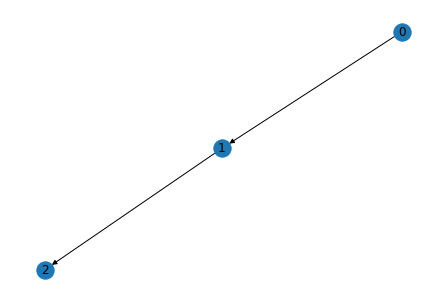

In [90]:
%matplotlib inline

gPINN = GraphPINN()
gPINN.plotGraph()
print('Vin:', gPINN.Vin)
print('Vout:', gPINN.Vout)
gPINN.E
gPINN.pos

In [91]:
mode = 'deterministic'
mode = 'uniform'

N_0 = 1000
N_b = 1000
N_r = 4000

# Set random seed for reproducible results
tf.random.set_seed(0)

def drawCollocationPoints(N_0, N_b, N_r):
    X_r = tf.random.uniform((N_r,2), lb, ub, dtype=DTYPE)
    
    # Draw uniform sample points for initial boundary data
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    
    # Boundary data
    t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
    x_l = tf.ones((N_b,1), dtype=DTYPE) * lb[1]
    X_l = tf.concat([t_b, x_l], axis=1)
    
    x_u = tf.ones((N_b,1), dtype=DTYPE) * ub[1]
    X_u = tf.concat([t_b, x_u], axis=1)
    
    X_b = tf.concat([X_l, X_u], axis=0)

    # Draw uniformly sampled collocation points
    t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    # X_data = tf.concat([X_0, X_b, X_r], axis=0)
    return X_r, X_0, X_l, X_u

if mode == 'deterministic':

    # Uniform distributed collocation points
    t_r = tf.linspace(lb[0], ub[0], N_0+1)
    x_r = tf.linspace(lb[1], ub[1], N_b+1)
    tt, xx = tf.meshgrid(t_r,x_r)
    X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)

elif mode == 'uniform':
    
    X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #X_data = tf.concat([X_0, X_b, X_r], axis=0)

Draw collocation points.

Text(0, 0.5, 'x')

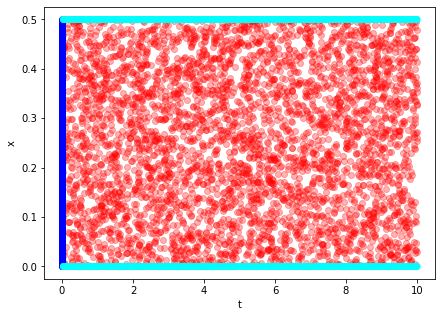

In [92]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0].numpy(), X_r[:,1].numpy(),color='red',alpha=0.3)
ax.scatter(X_0[:,0].numpy(), X_0[:,1].numpy(), color='blue', alpha=0.5)
ax.scatter(X_u[:,0].numpy(), X_u[:,1].numpy(), color='cyan', alpha=0.5)
ax.scatter(X_l[:,0].numpy(), X_l[:,1].numpy(), color='cyan', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel('x')

In [93]:
from time import time

class graphPINNSolver(object):
    def __init__(self, graphPINN):
        
        self.graphPINN = graphPINN
        self.ne = self.graphPINN.ne

        
        

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(self.ne):
            self.graphPINN.NNs[i](tf.constant([[1., 1.]], dtype=DTYPE))
            self.trainable_variables.append(self.graphPINN.NNs[i].trainable_variables)
        
        # Setup auxiliary variables for vertex values to ensure continuity
        self._setupVertexVariables()
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            self.trainable_variables.append([self.vertexVals[i]])
        
        self.nvar = len(self.trainable_variables)
        
    def _updateData(self, Xr, X0, Xl, Xu):
        self.Xr = Xr
        self.X0 = X0
        self.Xl = Xl
        self.Xu = Xu
        
        self.nr = Xr.shape[0]
        self.n0 = X0.shape[0]
        self.nb = Xl.shape[0]
        
        
    def decompose_data(self, X, N_0 = 1000, N_b = 1000, N_r = 4000):
        self.Xr = tf.convert_to_tensor(X[:N_r, :])
        self.X0 = tf.convert_to_tensor(X[N_r:(N_r+N_0), :])
        self.Xl = tf.convert_to_tensor(X[(N_r+N_0):(N_r+N_0+N_b), :])
        self.Xu = tf.convert_to_tensor(X[(N_r+N_0+N_b):, :])
        self.nr = N_r
        self.n0 = N_0
        self.nb = N_b
        

    def _setupVertexVariables(self):
        
        self.vertexVals = []
        for _ in self.graphPINN.innerVertices:
            self.vertexVals.append(tf.Variable(tf.random.uniform(shape=(1000,), dtype=DTYPE), trainable=True))

            
    def _fvals0(self, tx):

        # Initialize lists for values and derivatives
        u = []
        for i in range(self.ne):
            u.append(self.graphPINN.NNs[i](tx)[:,0])

        return u
    
    
    @tf.function
    def _fvals1(self, tx):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        
        for i in range(self.ne):
            output, gradient = self.graphPINN.NNs[i].get_gradient(tx)
            u.append(tf.reshape(output, [-1]))
            ut.append(gradient[0,:])
            ux.append(gradient[1,:])
                            
        return u, ut, ux
    
    
    @tf.function
    def _fvals2(self, tx):
        
        u = []
        ux = []
        ut = []
        uxx = []
        
        for i in range(self.ne):
            result = tf.vectorized_map(self.graphPINN.NNs[i].get_gradient_and_hessian, tx)
            u.append(tf.reshape(result[0], [-1]))
            ut.append(tf.reshape(result[1][:,0], [-1]))
            ux.append(tf.reshape(result[1][:,1], [-1]))
            uxx.append(result[2][:,1,1])
                            
        return u, ut, ux, uxx
    
   
    
    def determine_losses(self):
        # Short-hand notation of mean-squared loss
        mse = lambda x : tf.reduce_mean(tf.square(x))
        
        ###################################
        ### Residual loss for all edges ###
        ###################################
        # u, ut, ux, uxx = self._fvals2(self.Xr[:,0], self.Xr[:,1])
        u, ut, ux, uxx = self._fvals2(self.Xr)
        
        loss_res = 0
        for i in range(self.ne):
            res_e = pde(u[i], ut[i], ux[i], uxx[i])
            loss_res += mse(res_e)
        
        
        ###################################
        ### Initial conds for all edges ###
        ###################################
        
        # u = self._fvals0(self.X0[:,0], self.X0[:,1])
        u = self._fvals0(self.X0)
        
        loss_init = 0
        for i in range(self.ne):
            res_e = u[i] - initial_cond(self.X0[:,1])
            loss_init += mse(res_e)
        
        ###################################
        ###   Continuity in vertices    ###
        ###################################
        
        # ul, ult, ulx = self._fvals1(self.Xl[:,0], self.Xl[:,1])
        # uu, uut, uux = self._fvals1(self.Xu[:,0], self.Xu[:,1])
        ul, ult, ulx = self._fvals1(self.Xl)
        uu, uut, uux = self._fvals1(self.Xu)
        
        
        loss_cont = 0
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            
            for j in self.graphPINN.Vin[v]:
                val = uu[j] - self.vertexVals[i]
                loss_cont += mse(val)

            for j in self.graphPINN.Vout[v]:
                val = ul[j] - self.vertexVals[i]
                loss_cont += mse(val)

        #####################################
        ### Kirchhoff-Neumann in vertices ###
        #####################################
        
        # Kirchhoff-Neumann condition in center nodes
        loss_KN = 0
        for i in self.graphPINN.innerVertices:
            
            val = 0
            print('Kirchhoff-Neumann in node ', i)
            for j in self.graphPINN.Vin[i]:
                print('incoming edge:', j)
                val += flux(uu[j], uux[j])
                
            for j in self.graphPINN.Vout[i]:
                print('outgoing edge:', j)
                val -= flux(ul[j], ulx[j])
            loss_KN += mse(val)
        
        #####################################
        ###      Inflow/Outflow conds     ###
        #####################################
            
        loss_D = 0
        for i,v in enumerate(self.graphPINN.dirichletNodes):
            
            if time_dependent:
                alpha = self.graphPINN.dirichletAlpha[i](self.Xl[:,0])
                beta = self.graphPINN.dirichletBeta[i](self.Xl[:,0])
            else:
                alpha = self.graphPINN.dirichletAlpha[i]
                beta = self.graphPINN.dirichletBeta[i]
            
            print('\nin node ', v, 'alpha ', alpha, 'beta ', beta)
            val = 0
            for j in self.graphPINN.Vin[v]:
                print('outflow: ', j)
                val += flux(uu[j], uux[j]) \
                    - beta * (uu[j])
                #loss_D += mse(val)

            for j in self.graphPINN.Vout[v]:
                print('inflow: ', j)
                val += -flux(ul[j], ulx[j]) \
                    + alpha * (1-ul[j])
                #loss_D += mse(val)
            loss_D += mse(val)
        print(loss_res)
        print(loss_init)
        print(loss_cont)
        print(loss_KN)
        print(loss_D)
        return loss_res, loss_init, loss_cont, loss_KN, loss_D
    
    def loss_fn(self):
        
        loss_res, loss_init, loss_cont, loss_KN, loss_D = self.determine_losses()
        
        loss = loss_res + loss_init + loss_cont + loss_KN + loss_D

        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 20 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [94]:
solver = graphPINNSolver(gPINN)
X_test = tf.random.uniform((4000,2), dtype=DTYPE)
u, ut, ux, uxx = solver._fvals2(X_test)
print(u)
print(ut)
print(ux)
print(uxx)

[<tf.Tensor: shape=(4000,), dtype=float64, numpy=
array([0.57740436, 0.57698244, 0.5778954 , ..., 0.57705167, 0.57739834,
       0.57673851])>, <tf.Tensor: shape=(4000,), dtype=float64, numpy=
array([0.57740436, 0.57698244, 0.5778954 , ..., 0.57705167, 0.57739834,
       0.57673851])>]
[<tf.Tensor: shape=(4000,), dtype=float64, numpy=
array([-0.00185681, -0.00223771, -0.00232135, ..., -0.00230158,
       -0.00209334, -0.00173753])>, <tf.Tensor: shape=(4000,), dtype=float64, numpy=
array([-0.00185681, -0.00223771, -0.00232135, ..., -0.00230158,
       -0.00209334, -0.00173753])>]
[<tf.Tensor: shape=(4000,), dtype=float64, numpy=
array([-0.0020172 , -0.00210902, -0.00206132, ..., -0.00210228,
       -0.00207424, -0.0020673 ])>, <tf.Tensor: shape=(4000,), dtype=float64, numpy=
array([-0.0020172 , -0.00210902, -0.00206132, ..., -0.00210228,
       -0.00207424, -0.0020673 ])>]
[<tf.Tensor: shape=(4000,), dtype=float64, numpy=
array([-2.33534947e-04, -1.05844604e-04, -8.30439048e-05, ...,
  

In [95]:
import keras_tuner as kt


class HyperRegressor(kt.HyperModel):
    def build(self, hp):

        return PINN(num_hidden_layers = hp.Int("num_layers", min_value=0, max_value=9, step=1), 
                    num_neurons_per_layer = hp.Int("num_neurons_per_layer", min_value=2, max_value=32, step=1),
                    use_activation = hp.Boolean("use_activation"),
                    activation = hp.Choice("activation", ["sigmoid", "tanh", "relu", "elu", "gelu", "hard_sigmoid", "linear", "selu", "softplus", "swish"]),
                    use_activation_output = hp.Boolean("use_activation_output"),
                    activation_output = hp.Choice("activation_output", ["sigmoid", "tanh", "relu", "elu", "gelu", "hard_sigmoid", "linear", "selu", "softplus", "swish"]))
    

    

    def fit(self, hp, model, x, y, validation_data, **kwargs):
        solver = graphPINNSolver(GraphPINN(model = model))
        solver.decompose_data(x)
        
        # ADAM 
        lr = 0.01
        optim = tf.keras.optimizers.Adam(learning_rate=lr)
        
        t_1 = time()
        
        solver.solve_with_TFoptimizer(optim, N=2001)
        
        timediff_1 = time()-t_1
        
        # Wir wollen nicht so lange warten
        if timediff_1 > 60:
            return 100
        
        # LBFGS
        t_2 = time()
        
        solver.solve_with_ScipyOptimizer(options={'maxiter': 5000, 'maxfun': 50000, 'maxcor': 50, 'maxls': 50, 'ftol': 1.0*np.finfo(float).eps})
        
        timediff_2 = time()-t_2
        
        
        loss = solver.loss_fn().numpy()
        
        timediff = timediff_1 + timediff_2
        
        # Vielleicht andere loss-funktion
        loss_complete = 0.5 * loss / 0.001 + 0.4 * timediff / 180 + 0.1 * solver.iter / 7000
        
        if loss > 0.001 or timediff > 180:
            return 5 * loss_complete
        else: 
            return loss_complete



#tuner = kt.RandomSearch(hypermodel=HyperRegressor(), max_trials=2)

tuner = kt.BayesianOptimization(hypermodel=HyperRegressor(), max_trials = 3840, overwrite=True, directory="./my_dir", project_name="test_24.01.2022")

tf.random.set_seed(1)

X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
X = tf.concat([X_r, X_0, X_l, X_u], 0)

tuner.search(x=X, y=None, validation_data=0)

tuner.results_summary()

print(tuner.get_best_hyperparameters()[0].values)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
num_layers        |1                 |?                 
num_neurons_per...|20                |?                 
use_activation    |True              |?                 
activation        |swish             |?                 
use_activation_...|True              |?                 
activation_output |swish             |?                 

Initialized 2 neural nets.
 Iter            Loss    Time
-----------------------------
Kirchhoff-Neumann in node  1
incoming edge: 0
outgoing edge: 1

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  2 alpha  0.0 beta  0.8
outflow:  1
Tensor("add_3:0", shape=(), dtype=float64)
Tensor("add_5:0", shape=(), dtype=float64)
Tensor("add_7:0", shape=(), dtype=float64)
Tensor("add_11:0", shape=(), dtype=float64)
Tensor("add_18:0", shape=(), dtype=float64)
00000  9.03866414e-01   11.55
00020  1.74254405e-01   16.55
00040  8.09171292e-02   21.92


KeyboardInterrupt: 

In [17]:
#solver.graphPINN.NNs[0](tf.constant([[1., 1.]]))

In [79]:
gPINN = GraphPINN()
N_0 = 1000
N_b = 1000
N_r = 4000
solver = graphPINNSolver(gPINN)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
X = tf.concat([X_r, X_0, X_l, X_u], 0)
solver.decompose_data(X)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 2 neural nets.


Check accuracy of explicit derivatives in relation to gradient tape (automatic differentiation).  

In [19]:
tf.random.set_seed(1)
X_test = tf.random.uniform((4000,2), dtype=DTYPE)
t1 = time()
u, ut, ux = solver._fvals1(X_test)
tdiff1 = time() - t1
print(tdiff1)
t2 = time()
u_ad, ut_ad, ux_ad = solver._fvals1_ad(X_test[:,0], X_test[:,1])
tdiff2 = time() - t2
print(tdiff2)
print(tdiff1/tdiff2)

0.4316542148590088
0.012967348098754883
33.28777877879718


In [20]:
print(tf.linalg.norm(tf.concat(u, 0)-tf.concat(u_ad, 0)))
print(tf.linalg.norm(tf.concat(ut, 0)-tf.concat(ut_ad, 0)))
print(tf.linalg.norm(tf.concat(ux, 0)-tf.concat(ux_ad, 0)))

tf.Tensor(6.0031659246912336e-15, shape=(), dtype=float64)
tf.Tensor(6.1233605888667225e-15, shape=(), dtype=float64)
tf.Tensor(5.943064397775477e-15, shape=(), dtype=float64)


In [21]:
tf.random.set_seed(1)
X_test = tf.random.uniform((4000,2), dtype=DTYPE)
t1 = time()
u, ut, ux, uxx = solver._fvals2(X_test)
tdiff1 = time() - t1
print(tdiff1)
t2 = time()
u_ad, ut_ad, ux_ad, uxx_ad = solver._fvals2_ad(X_test[:,0], X_test[:,1])
tdiff2 = time() - t2
print(tdiff2)
print(tdiff1/tdiff2)

1.7395343780517578
0.019948244094848633
87.20238081009693


In [22]:
# print(u)
# print(ut)
# print(ux)
# print(uxx)

In [23]:
# print(u_ad)
# print(ut_ad)
# print(ux_ad)
# print(uxx_ad)

In [24]:
print(tf.linalg.norm(tf.concat(u, 0)-tf.concat(u_ad, 0)))
print(tf.linalg.norm(tf.concat(ut, 0)-tf.concat(ut_ad, 0)))
print(tf.linalg.norm(tf.concat(ux, 0)-tf.concat(ux_ad, 0)))
print(tf.linalg.norm(tf.concat(uxx, 0)-tf.concat(uxx_ad, 0)))

tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(6.099157487868988e-15, shape=(), dtype=float64)
tf.Tensor(5.9368391191139686e-15, shape=(), dtype=float64)
tf.Tensor(1.2462222543165673e-15, shape=(), dtype=float64)


The question remains what is more accurate for the second partial derivative. 

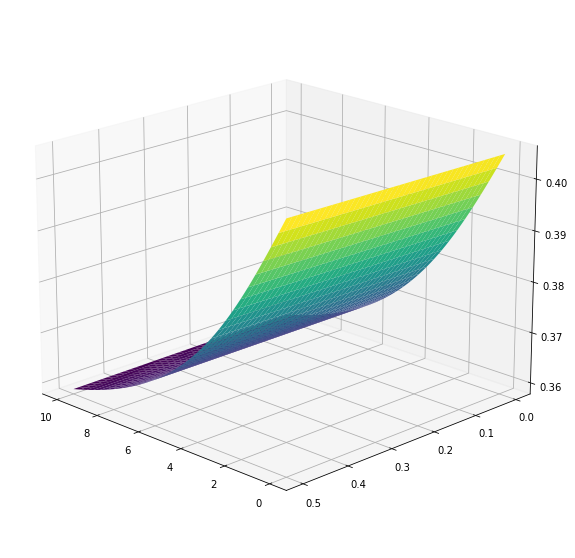

In [76]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


In [80]:
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver.solve_with_TFoptimizer(optim, N=2001)
#for i in range(20):
    # WARNING: Update of collocation points currently not supported
    # Vertex values are fixed for coordinates at boundary!
    #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #solver._updateData(X_r, X_0, X_l, X_u)
    #solver.solve_with_TFoptimizer(optim, N=301)


Start with TF optimizer

 Iter            Loss    Time
-----------------------------
Kirchhoff-Neumann in node  1
incoming edge: 0
outgoing edge: 1

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  2 alpha  0.0 beta  0.8
outflow:  1
Tensor("add_3:0", shape=(), dtype=float64)
Tensor("add_5:0", shape=(), dtype=float64)
Tensor("add_7:0", shape=(), dtype=float64)
Tensor("add_11:0", shape=(), dtype=float64)
Tensor("add_18:0", shape=(), dtype=float64)
00000  5.74638595e-01   10.16
00020  1.53389568e-01   15.07
00040  7.51891020e-02   20.40


KeyboardInterrupt: 

In [27]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*1)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  4.28194495e-02   1.25
02040  3.21848849e-02   2.24
02060  2.20452730e-02   3.30
02080  2.06480537e-02   4.42
02100  1.81486921e-02   5.69
02120  1.74634523e-02   6.96
02140  1.67801545e-02   8.07
02160  1.63505441e-02   9.27
02180  1.62484019e-02   10.35
02200  1.58583412e-02   11.77
02220  1.57250606e-02   12.99
02240  1.52252929e-02   14.20
02260  1.47409929e-02   15.48
02280  1.42373548e-02   16.89
02300  1.21683643e-02   18.66
02320  1.19205510e-02   19.89
02340  1.15696200e-02   21.09
02360  1.13784958e-02   22.38
02380  1.13130211e-02   23.75
02400  1.11016020e-02   25.37
02420  1.10575224e-02   26.64
02440  1.08940431e-02   28.23
02460  1.05890414e-02   29.83
02480  1.02382949e-02   31.21
02500  9.84757437e-03   32.64
02520  9.48825988e-03   33.89
02540  9.07800706e-03   35.14
02560  8.89808280e-03   36.31
02580  8.80715388e-03   37.54
02600  8.78656781e-03   38.70
02620  8.74489767e-0

In [28]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig = plt.figure(1, figsize=(10, 10))
#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
def plot_network(j=0):
    fig = plt.figure(1,clear=True)
    ax = fig.add_subplot(1,1,1, projection='3d')
    t0 = tf.ones_like(xspace)*tspace[j]
    pos = solver.graphPINN.pos
    for i, e in enumerate(solver.graphPINN.E):
        xy = pos[e[0]] + xspace*(pos[e[1]] - pos[e[0]]) / (ub[1]-lb[1])
        #xy = pos[e[0].numpy()] + xspace*(pos[e[1].numpy()] - pos[e[0].numpy()]) 
        #xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = solver.graphPINN.NNs[i](tf.concat([t0,xspace],axis=1))
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
        #ax.plot(xy[:,0], xy[:,1], unum * (1-unum))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([.0,1.0])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(12, 135)
    return u

j_slider = widgets.IntSlider(min=0,max=Nt,step=1)
interactive_plot = interactive(plot_network, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

interactive(children=(IntSlider(value=0, description='j', max=60), Output()), _dom_classes=('widget-interact',…

<Figure size 720x720 with 0 Axes>

Surface plot of function values on a single edge.

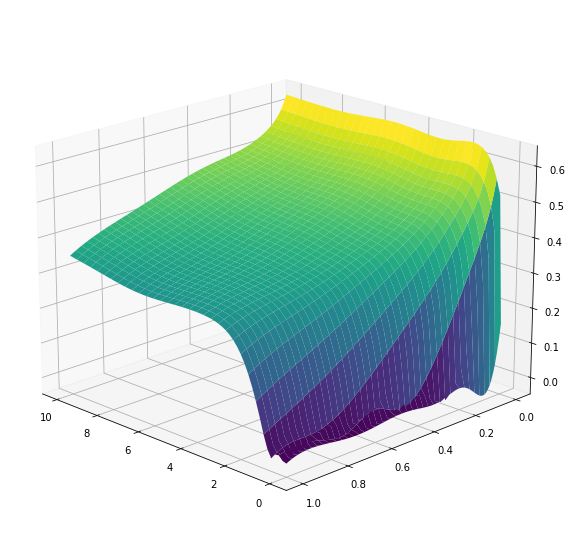

In [29]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)
